Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

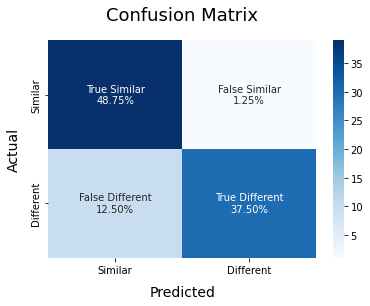

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from Siamese_utilities import *
import time
from Data_Preparation import *

import matplotlib.pyplot as plt
import cv2
train_images, test_images = get_dataset()
train_triplets = get_triplet(train_images)
test_triplets = get_triplet(test_images)

siamese_model = generate_Siamese_model()
siamese_model.build(input_shape=())
siamese_model.load_weights('/content/siamese_model-final.h5')

encoder = get_encoder((128, 128, 3))
encoder.load_weights('/content/encoder.h5')


def classify_images(signature_list1, signature_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(signature_list1)
    tensor2 = encoder.predict(signature_list2)

    distance = np.sum(np.square(tensor1 - tensor2), axis=-1)
    prediction = np.where(distance <= threshold, 0, 1)
    return prediction


def ModelMetrics(pos_list, neg_list):
    true = np.array([0] * len(pos_list) + [1] * len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories = ['Similar', 'Different']
    names = ['True Similar', 'False Similar', 'False Different', 'True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplets, batch_size=40):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)
